In [5]:
# Import packages
import pandas as pd
import numpy as np
import os
import numpy as np
from scipy import stats
from sklearn.preprocessing import RobustScaler
# Improt packages
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so

In [ ]:
df = pd.read_csv('merged.csv', sep=';')
df

In [ ]:
df.to_csv('merged_UTR.csv', index = False)

In [ ]:
df = df[df['molecularSubtype']!='normal']
df = df[df['transcript_length']>200]

In [ ]:
df2 = pd.read_csv('UTR_start_stop_id')

In [ ]:
df = pd.merge(df, df2, on='reference_id')

In [ ]:
# Add the column "utr_length"
df['UTR_length'] = np.where(df['strand'] == '+', df['end'] - df['Start_UTRref'], df['End_UTRref'] - df['start'] + 1)

In [ ]:
# Add column with UTR length from ncbi reference
df['ref_UTR_length'] = df['End_UTRref'] - df['Start_UTRref']

# Add column with difference between UTR and reference
df['UTR_diff'] = df['UTR_length'] - df['ref_UTR_length']

In [ ]:
# Logarithmic transformation
df['UTR_length (ln)'] = np.log(df['UTR_length'])

In [ ]:
df = df[df['UTR_length']>0]

In [ ]:
conditions = [
    df['UTR_diff'] < 0,   # Values lower than -1
    df['UTR_diff'].isin([0]),   # Values -1 or 0
    df['UTR_diff'] > 0   # Values greater than 0
]

choices = ['shorter', 'no change', 'longer']

df['UTR_type'] = np.select(conditions, choices, default='unknown')

In [ ]:
df = df.sort_values('molecularSubtype')
# plt.figure(figsize=())
g = sns.displot(df, x="UTR_length (ln)", col='filename', hue = 'molecularSubtype', col_wrap=4, palette='Set2')
# g = plt.title("Rozkład długości 3'UTR (log) dla podtypów nowotworu piersi")
g = sns.set_theme()
g = sns.set_context("paper")



# Set plot title and labels

plt.savefig("distribution_sample.png")


In [ ]:
# df2 = df.drop('filename', axis=1)
df2 = df.drop('FPKM', axis=1)
df2 = df2.drop('TPM', axis=1)
df2 = df2.drop('cov', axis=1)

In [ ]:
df2 = df2.drop_duplicates()
df2 = df2.reset_index()
df2 = df2.drop('index', axis=1)

In [ ]:
df2.to_csv('UTR_filename.csv', index=False)

In [6]:
df2 = pd.read_csv('../APTARDI/UTR_filename.csv')

In [ ]:
# Z-scores
df['z_score_diff'] = stats.zscore(df['UTR_diff'])

# Create a RobustScaler object
scaler = RobustScaler()

column_array = df['UTR_diff'].values

# Reshape the array to a 2D array
reshaped_array = column_array.reshape(-1, 1)

# Fit the scaler to the dataset and transform the data
df['scaled_diff'] = scaler.fit_transform(reshaped_array)

In [ ]:
# Group by 'molecularSubtype' and 'gene_id', and filter out rows with the same 'utr lengths'
df2 = df2.groupby(['molecularSubtype', 'ref_gene_id']).apply(lambda x: x.drop_duplicates(subset='transcript_length'))

# Reset the index of the filtered DataFrame
df2 = df2.reset_index(drop=True)

# Print the resulting DataFrame
print(df2)

In [ ]:
df2

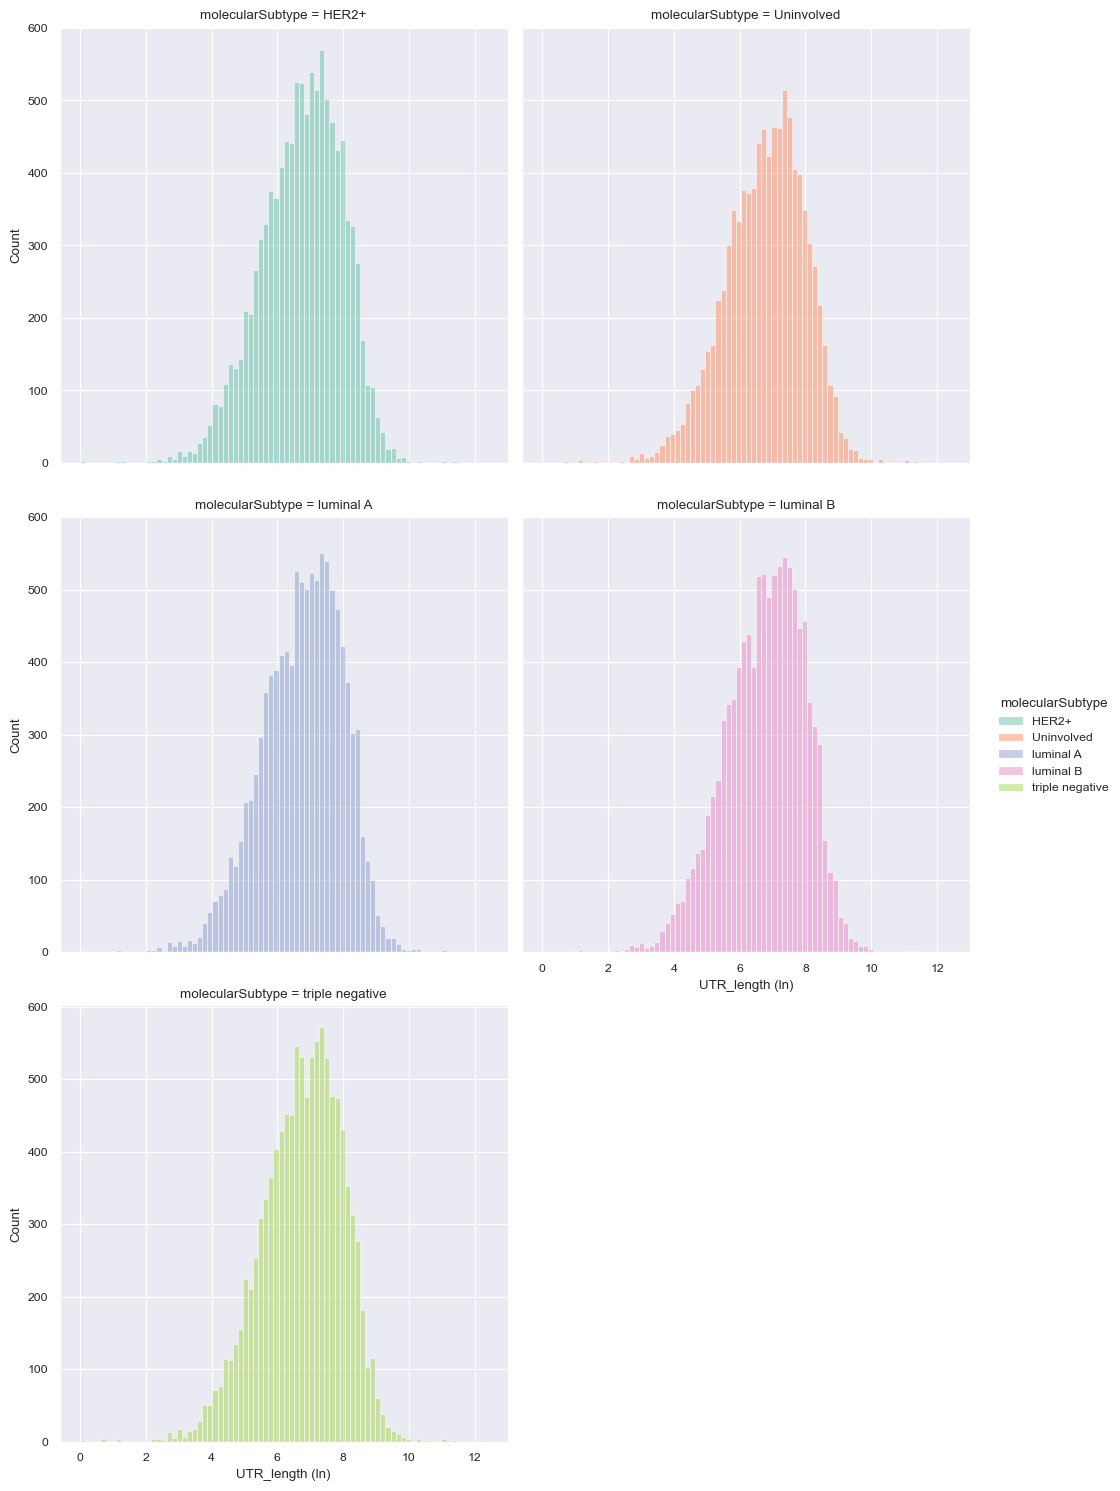

In [8]:
# plt.figure(figsize=())
g = sns.displot(df2, x="UTR_length (ln)", col='molecularSubtype', hue = 'molecularSubtype',  palette='Set2', bins=80, col_wrap=2)
# g = plt.title("Rozkład długości 3'UTR (log) dla podtypów nowotworu piersi")
g = sns.set_theme()
g = sns.set_context("paper")



# Set plot title and labels

# plt.savefig("distribution_2.png")

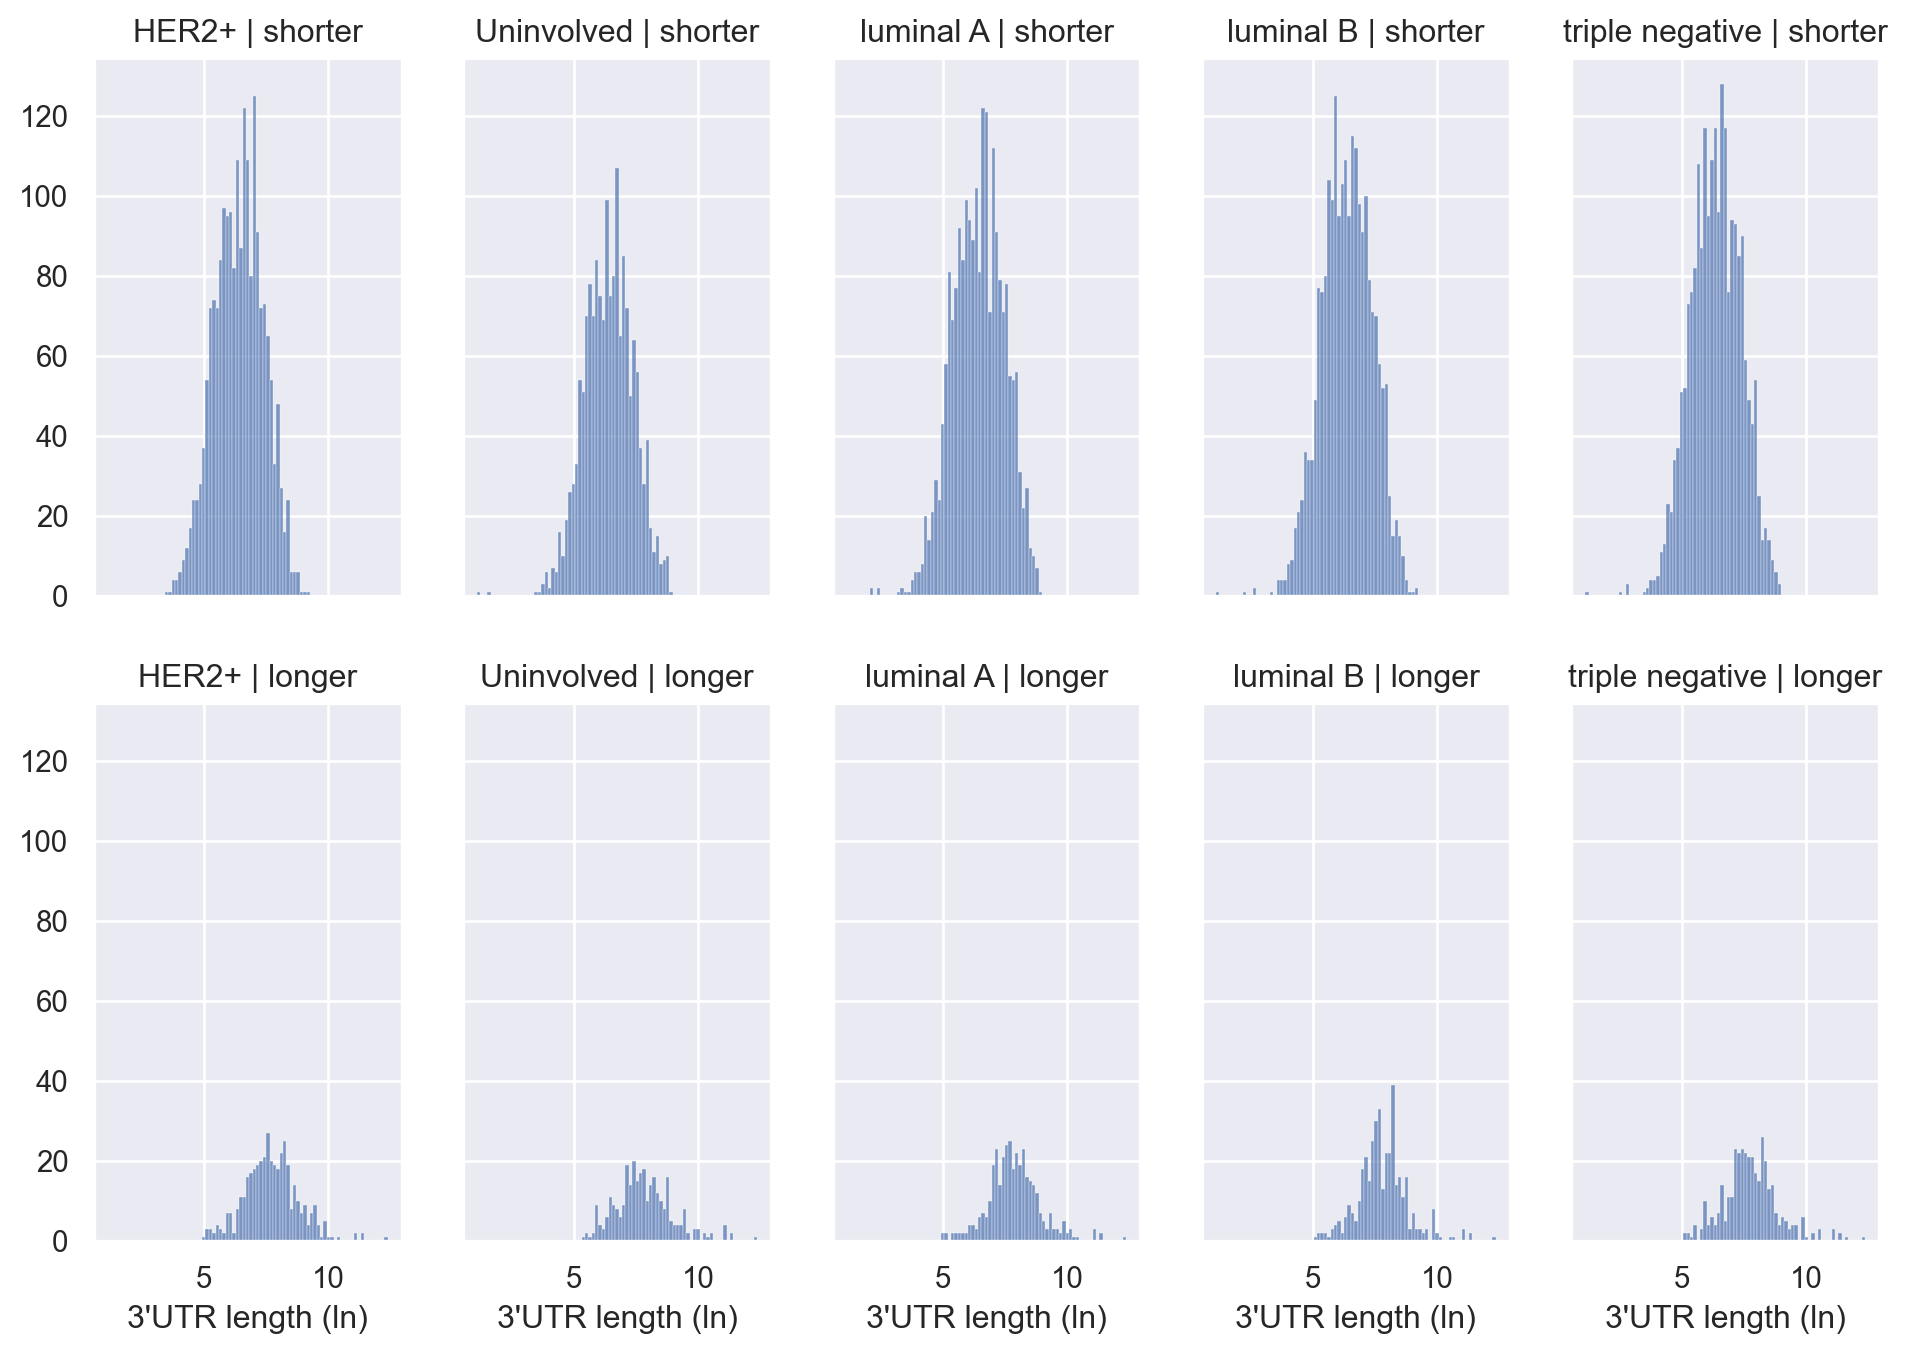

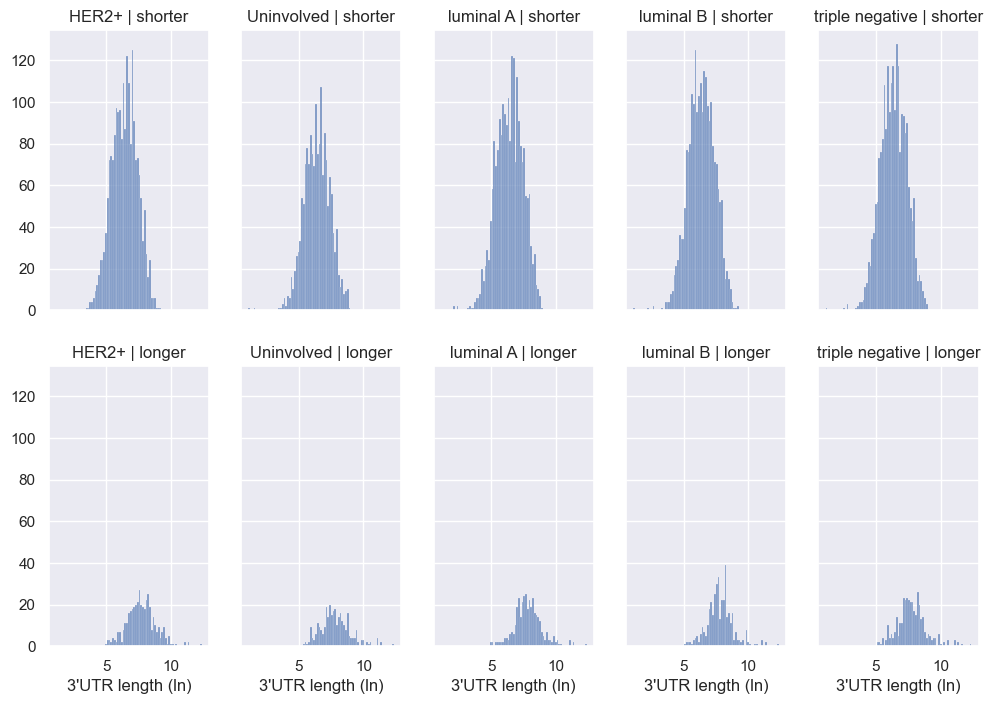

In [9]:
df3 = df2[df2['UTR_type']!='no change']
f = plt.figure(figsize=(12, 8))
#sf1, sf2 = f.subfigures(1, 2)
fig = (
    so.Plot(df3, x="UTR_length (ln)")
    .facet(col="molecularSubtype", row="UTR_type")
    .add(so.Bars(), so.Hist(), so.Dodge())
    .on(f)
    .label(
        x="3'UTR length (ln)", y="",
        color=str.capitalize
    )
    # .save("distribution_type.png")
)
fig

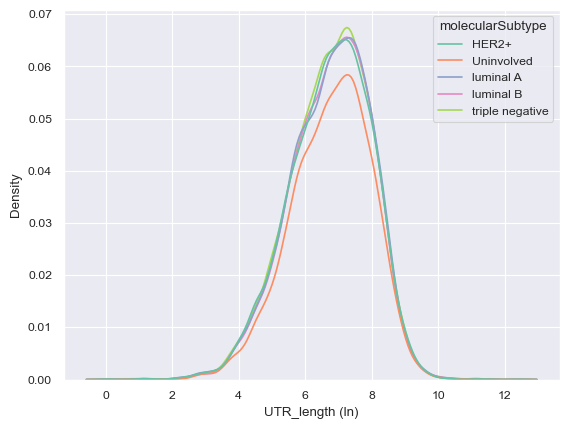

In [10]:
sns.kdeplot(data=df2, x="UTR_length (ln)", hue="molecularSubtype", palette='Set2')
sns.color_palette()
# plt.subtitle("Wykres gęstości długości 3'UTR (log) dla podtypów molekularnych")
sns.set_theme()
sns.set_context("paper")
# plt.savefig("density.png", dpi=300)

In [11]:
df2 = df2[df2['UTR_type']!='no change']

In [14]:
# Group dataframe by molecular subtype
grouped = df2.groupby('molecularSubtype')

# Count the occurrences of longer and shorter UTR types
counts = grouped['UTR_type'].value_counts()
counts
counts.to_csv('../APTARDI/counts_nosample.csv') # Save to file

In [ ]:
counts

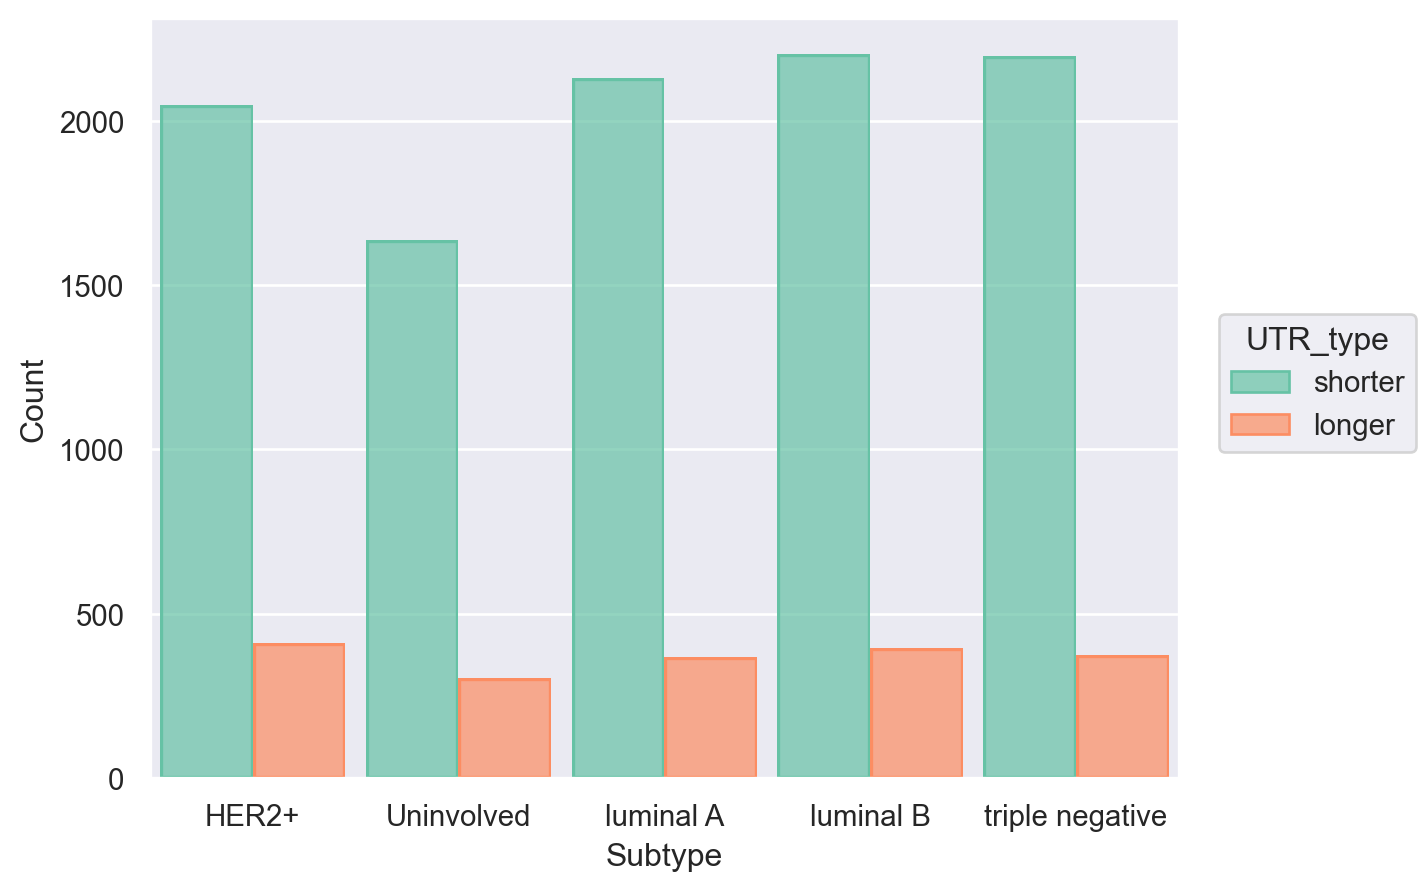

In [15]:
counts = pd.read_csv('../APTARDI/counts_nosample.csv')
fig = (
    so.Plot(counts, x="molecularSubtype", y="count", color="UTR_type")
    .add(so.Bar(width=0.9), so.Agg(), so.Dodge())
    # .add(so.Text(color="black", halign="right"))
    .label(x="Subtype", y='Count')
    .scale(color="Set2")
    .save('counts.png')
    
)
fig

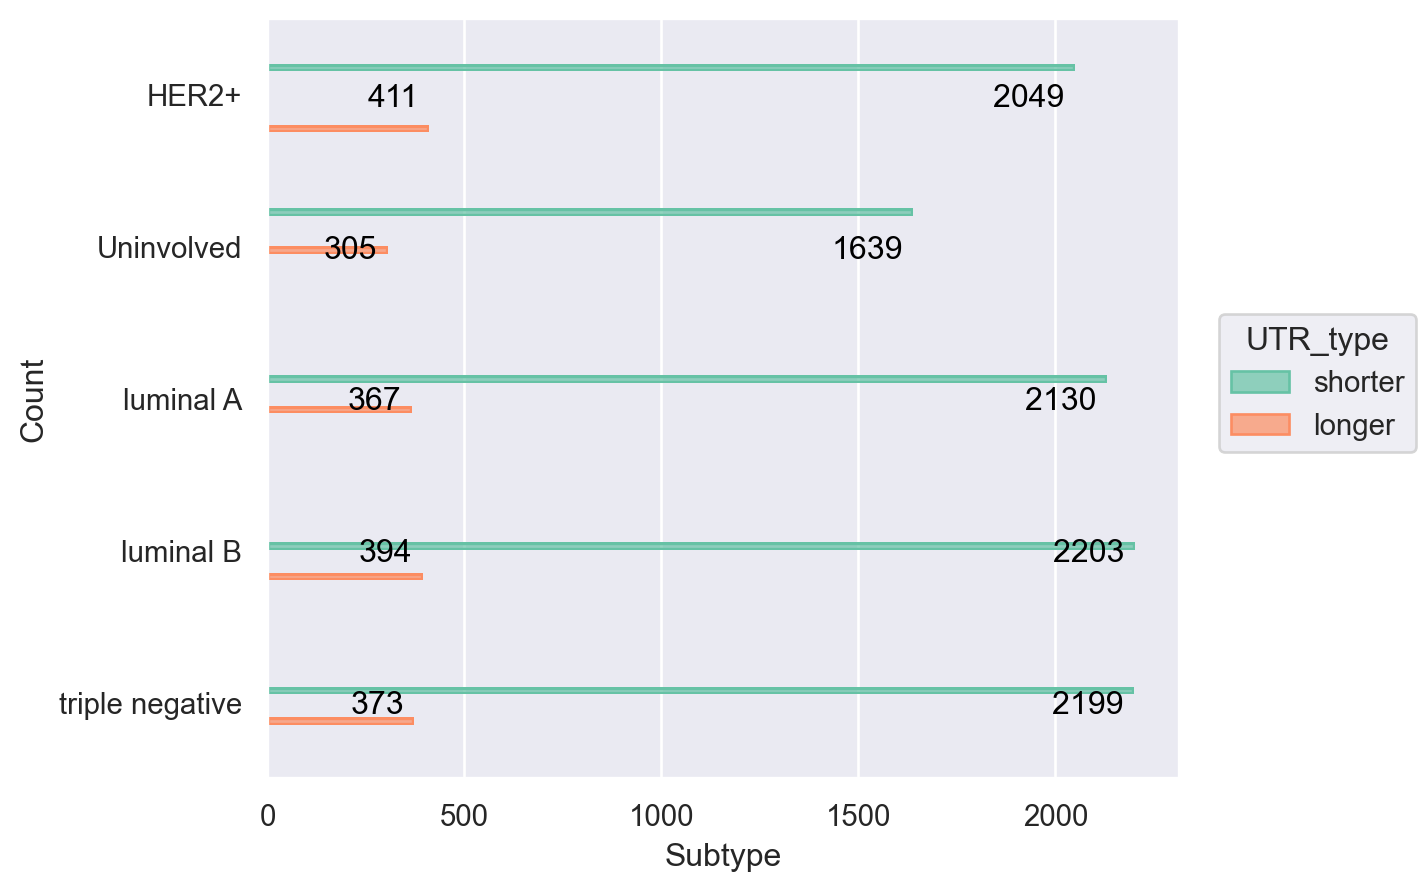

In [16]:
counts = counts[counts['UTR_type']!='no change']
fig = (
    so.Plot(counts, x="count", y="molecularSubtype", color="UTR_type", text="count")
    .add(so.Bar(width=1), so.Agg(), so.Dodge())
    .add(so.Text(color="black", halign="right"))
    .label(x="Subtype", y='Count')
    .scale(color="Set2")
    # .add(so.Text(color="b", halign="center"))
    # .save('counts_changed.png')
    
)
fig

In [17]:
# Group df by molecular subtype and save to grouped df
grouped = df2.groupby('molecularSubtype')
grouped = grouped[['reference_id', 'UTR_type']]

# Save each group to separate csv
for name, group in grouped:
    group = group[group['UTR_type']=='longer']
    filename = f"{name}_longer.csv"  
    group['reference_id'].to_csv(filename, index=False)
    print(f"Group '{name}' saved to '{filename}'.")

Group 'HER2+' saved to 'HER2+_longer.csv'.
Group 'Uninvolved' saved to 'Uninvolved_longer.csv'.
Group 'luminal A' saved to 'luminal A_longer.csv'.
Group 'luminal B' saved to 'luminal B_longer.csv'.
Group 'triple negative' saved to 'triple negative_longer.csv'.


In [18]:
short = df2[df2['UTR_type']=='shorter']
long = df2[df2['UTR_type']=='longer']

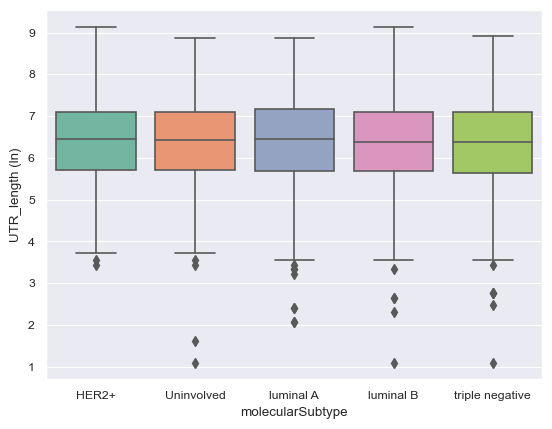

In [19]:
sns.boxplot(data=short, x="molecularSubtype", y="UTR_length (ln)", palette='Set2')
sns.set_context("paper")
sns.set_theme()
# plt.savefig("box_short.png", dpi=300)

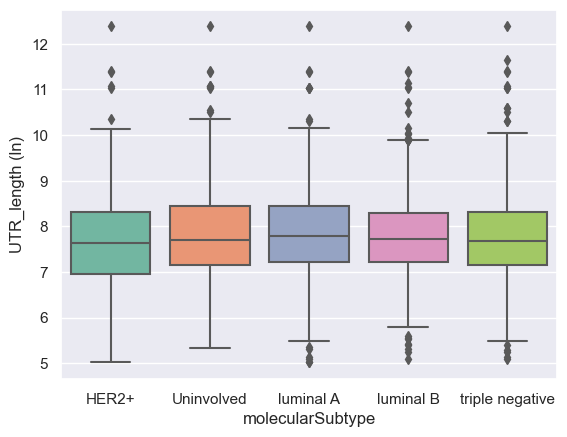

In [20]:
sns.boxplot(data=long, x="molecularSubtype", y="UTR_length (ln)", palette='Set2')
sns.set_context("paper")
sns.set_theme()
# plt.savefig("box_long.png", dpi=300)

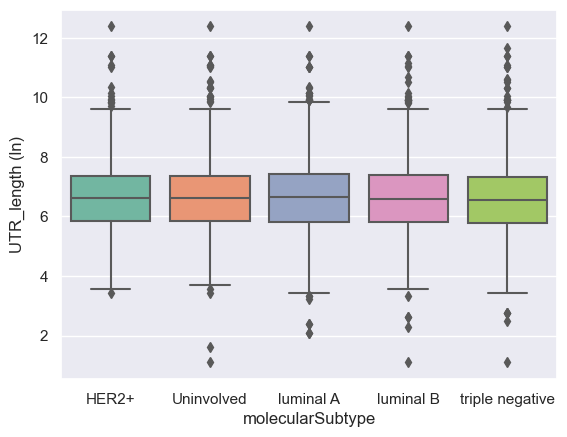

In [21]:
sns.boxplot(data=df2, x="molecularSubtype", y="UTR_length (ln)", palette='Set2')
sns.set_context("paper")
sns.set_theme()

# plt.savefig("box_all.png", dpi=300)

DEG triple vs control

In [ ]:
df_trip = filtered_df2[filtered_df2['molecularSubtype']=='triple negative']

In [ ]:
df_deg = pd.read_csv('all_trip_results.csv')

In [ ]:
trip_merged = pd.merge(df_trip, df_deg, on='reference_id')

In [ ]:
trip_merged = trip_merged[trip_merged['UTR_type']!='no change']


In [ ]:
trip_merged = trip_merged[['reference_id', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']]

In [ ]:
trip_merged = trip_merged.dropna()

In [ ]:
trip_merged = trip_merged.drop_duplicates()
trip_merged = trip_merged.reset_index()
trip_merged = trip_merged.drop('index', axis=1)

In [ ]:
trip_merged.to_csv('triple_function.csv', index=False)

In [ ]:
trip_merged

DEG her 

In [ ]:
df_her = filtered_df2[filtered_df2['molecularSubtype']=='HER2+']

In [ ]:
df_deg = pd.read_csv('../../../DEG/HER_DEG/all_her_results.csv')

In [ ]:
her_merged = pd.merge(df_her, df_deg, on='reference_id')

In [ ]:
her_merged

In [ ]:
her_merged = her_merged[her_merged['UTR_type']!='no change']

In [ ]:
her_merged = her_merged.dropna()

In [ ]:
her_merged = her_merged.reset_index()
her_merged = her_merged.drop('index', axis=1)

In [ ]:
her_merged.to_csv('her_deg_UTR.csv', index=False)

In [ ]:
her_utr_deg = her_merged[['reference_id', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']]

In [ ]:
her_utr_deg = her_utr_deg.drop_duplicates()

In [ ]:
her_utr_deg.to_csv('her_function.csv', index=False)

tripleUniq + DEG


In [ ]:
tripUniq = pd.read_table('/Users/natdzi3/mgr/DEG/DEG_triple/funkcja/tripUniq.txt' )
tripUniq = tripUniq[['reference_id']]
tripUniq

In [ ]:
df_deg = pd.read_csv('all_trip_results.csv')

In [ ]:
trip_merged = pd.merge(tripUniq, df_deg, on='reference_id')

In [ ]:
trip_merged

In [ ]:
trip_merged.to_csv('tripUniq_deg.csv', index='False')

In [ ]:
trip_long.to_csv('tripUniq_long_deg.csv', index='False')

herUniq + DEG

In [ ]:
HERUniq = pd.read_table('/Users/natdzi3/mgr/DEG/HER_DEG/funkcja/HERuniq.txt' )
HERUniq = HERUniq[['reference_id']]
HERUniq

In [ ]:
df_deg = pd.read_csv('../../../DEG/HER_DEG/all_her_results.csv')

In [ ]:
her_merged = pd.merge(HERUniq, df_deg, on='reference_id')

In [ ]:
her_merged.to_csv('her_uniq_deg.csv', index=False)

In [ ]:
df = pd.read_csv('../../../DEG/HER_DEG/HER_res.csv')

In [ ]:
df2

In [ ]:
df2 = pd.read_csv('UTR_official.csv')

In [ ]:
df2 = df2[df2['molecularSubtype']=='HER2+']

In [ ]:
df2 = df2[df2['UTR_type']!='no change']
df2 = df2['reference_id']



In [ ]:
df2 = df2.drop_duplicates()

In [ ]:
df3 = pd.merge(df, df2, on='reference_id')

In [ ]:
df3 = df3.drop_duplicates()
df3 = df3.reset_index()
df3 = df3.drop('index', axis=1)


In [ ]:
df3

In [ ]:
df3.to_csv('../../../DEG/HER_DEG/her_res_changedUTR.csv', index=False)

In [63]:
df = pd.read_csv('UTR_filename.csv')

In [4]:
-df

,seqname,source,feature,start,end,strand,ref_gene_id,reference_id,filename,transcript_length,molecularSubtype,Start_UTRref,End_UTRref,UTR_length,ref_UTR_length,UTR_diff,UTR_length (ln),UTR_type
0,chr22,StringTie,transcript,42692115,42720870,-,A4GALT,XM_005261647.3,SRR19969243,28755,HER2+,42692114,42692889,775,775,0,6.652863,no change
1,chr22,StringTie,transcript,42692115,42694984,-,A4GALT,XM_011530233.2,SRR19969243,2869,HER2+,42692114,42692889,775,775,0,6.652863,no change
2,chr22,StringTie,transcript,42692121,42720870,-,A4GALT,NM_017436.7,SRR19969243,28749,HER2+,42692120,42692889,769,769,0,6.645091,no change
3,chr22,StringTie,transcript,42692121,42721301,-,A4GALT,NM_001318038.3,SRR19969243,29180,HER2+,42692120,42692889,769,769,0,6.645091,no change
4,chr22,StringTie,transcript,42692115,42720514,-,A4GALT,XM_006724266.3,SRR19969245,28399,HER2+,42692114,42692889,775,775,0,6.652863,no change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52385,chr10,StringTie,transcript,56357438,56361273,-,ZWINT,NM_001005413.1,SRR19969210,3835,triple negative,56357437,56358185,748,748,0,6.617403,no change
52386,chr10,StringTie,transcript,56357438,56361272,-,ZWINT,XM_017015605.2,SRR19969210,3834,triple negative,56357437,56358428,991,991,0,6.898715,no change
52387,chr10,StringTie,transcript,56357445,56361259,-,ZWINT,NM_032997.3,SRR19969210,3814,triple negative,56357444,56358417,973,973,0,6.880384,no change
52388,chrX,StringTie,transcript,57905430,57910458,-,ZXDA,NM_007156.5,SRR19969208,5028,triple negative,57905429,57908020,2591,2591,0,7.859799,no change


In [8]:
df_tripuniq = pd.read_csv('../../../DEG/DEG_triple/TNBC_uniq/top.csv')

In [9]:
merge = pd.merge(df, df_tripuniq, on='reference_id')

In [ ]:
merge

In [12]:
df_heruniq = pd.read_csv('../../../DEG/HER_DEG/changedUTR/top.csv')

In [15]:
merge_her = pd.merge(df, df_heruniq, on='reference_id')

In [16]:
merge_her.

,seqname,source,feature,start,end,strand,ref_gene_id,reference_id,filename,transcript_length,...,ref_UTR_length,UTR_diff,UTR_length (ln),UTR_type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,chr19,StringTie,transcript,44946051,44949565,+,APOC2,NM_000483.5,SRR19969243,3514,...,316,0,5.755742,no change,293.676843,2.997364,0.526608,5.691829,1.256858e-08,0.000002
1,chr19,aptardi,transcript,44946051,44949458,+,APOC2,NM_000483.5,SRR19969243,3407,...,316,-107,5.342334,shorter,293.676843,2.997364,0.526608,5.691829,1.256858e-08,0.000002
2,chr19,StringTie,transcript,44946051,44949565,+,APOC2,NM_000483.5,SRR19969233,3514,...,316,0,5.755742,no change,293.676843,2.997364,0.526608,5.691829,1.256858e-08,0.000002
3,chr19,StringTie,transcript,44946051,44949565,+,APOC2,NM_000483.5,SRR19969219,3514,...,316,0,5.755742,no change,293.676843,2.997364,0.526608,5.691829,1.256858e-08,0.000002
4,chr19,StringTie,transcript,44946051,44949565,+,APOC2,NM_000483.5,SRR19969212,3514,...,316,0,5.755742,no change,293.676843,2.997364,0.526608,5.691829,1.256858e-08,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,chr2,aptardi,transcript,5692384,5695683,+,SOX11,NM_003108.4,SRR19969244,3299,...,7338,-5702,7.400010,shorter,1206.771711,6.107050,1.155821,5.283731,1.265789e-07,0.000016
105,chr2,StringTie,transcript,5692384,5701385,+,SOX11,NM_003108.4,SRR19969216,9001,...,7338,0,8.900822,no change,1206.771711,6.107050,1.155821,5.283731,1.265789e-07,0.000016
106,chr2,StringTie,transcript,5692384,5701385,+,SOX11,NM_003108.4,SRR19969234,9001,...,7338,0,8.900822,no change,1206.771711,6.107050,1.155821,5.283731,1.265789e-07,0.000016
107,chr2,StringTie,transcript,5692384,5701385,+,SOX11,NM_003108.4,SRR19969219,9001,...,7338,0,8.900822,no change,1206.771711,6.107050,1.155821,5.283731,1.265789e-07,0.000016


In [64]:
df2 = pd.read_csv('../../../DEG/DEG_triple/TNBC_res.csv')

In [65]:
df=df[(df['molecularSubtype']=='triple negative')]


In [66]:
merged_pca = pd.merge(df,df2, on='reference_id')

In [67]:
merged_pca = merged_pca[merged_pca['padj']<0.05]


In [9]:
merged_pca=merged_pca.sort_values('molecularSubtype')

In [44]:
import matplotlib.pyplot as plt


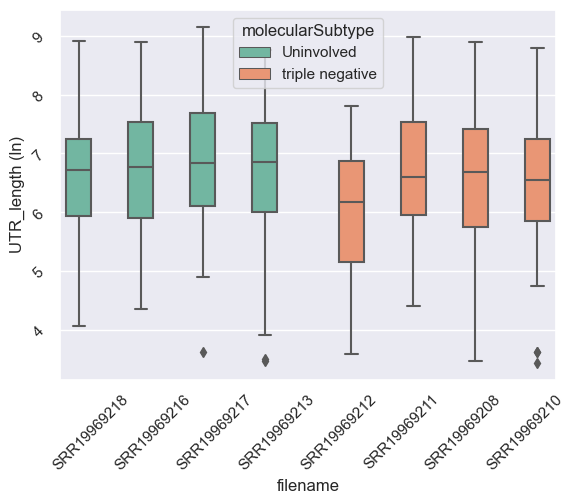

In [41]:

# Specify the variables and plot the boxplot
sns.set_context("paper")
sns.set_theme()
ax = sns.boxplot(data=deg_trip, x="filename", y="UTR_length (ln)", hue='molecularSubtype', palette='Set2')

# Change the angle of x-axis labels
plt.xticks(rotation=45)

# Change the angle of y-axis label
plt.yticks(rotation=45)

# Show the plot
plt.show()




In [12]:
deg_trip = merged_pca[abs(merged_pca['log2FoldChange'])>2]

In [14]:
deg_trip = deg_trip[merged_pca['baseMean']>50]

C:\Users\natdzi3\AppData\Local\Temp\ipykernel_20904\3811085830.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  deg_trip = deg_trip[merged_pca['baseMean']>50]


In [42]:
# Group dataframe by molecular subtype
grouped = merged_pca_her.groupby('filename')

# Count the occurrences of longer and shorter UTR types
counts = grouped['UTR_type'].value_counts()
counts
# counts.to_csv('counts_nosample.csv') # Save to file

filename     UTR_type 
SRR19969213  no change    298
             shorter       64
             longer         4
SRR19969216  no change    205
             shorter       51
             longer         9
SRR19969217  no change    118
             shorter       23
             longer         3
SRR19969218  no change     91
             shorter       20
             longer         6
SRR19969243  no change    294
             shorter       61
             longer         7
SRR19969244  no change    169
             shorter       50
             longer         3
SRR19969245  no change    128
             shorter       27
             longer         8
SRR19969246  no change    113
             shorter       36
             longer        14
Name: count, dtype: int64

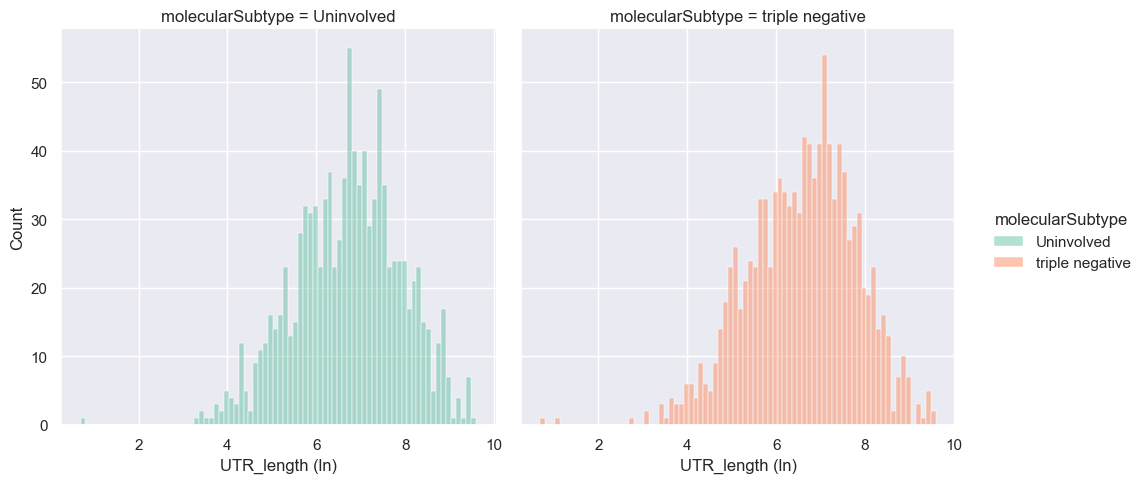

In [34]:
# plt.figure(figsize=())
g = sns.displot(merged_pca, x="UTR_length (ln)", col='molecularSubtype', hue = 'molecularSubtype',  palette='Set2', bins=80, col_wrap=2)
# g = plt.title("Rozkład długości 3'UTR (log) dla podtypów nowotworu piersi")
g = sns.set_theme()
g = sns.set_context("paper")



# Set plot title and labels

# plt.savefig("distribution_2.png")

In [58]:
df=df[(df['molecularSubtype']=='HER2+')]


In [59]:
df2 = pd.read_csv('../../../DEG/HER_DEG/her_res.csv')

In [60]:
merged_pca_her = pd.merge(df,df2, on='reference_id')

In [61]:
merged_pca_her = merged_pca_her[merged_pca_her['padj']<0.05]

In [62]:
merged_pca_her.to_csv('../../../DEG/HER_DEG/pca/pca_her.csv')

In [50]:
merged_pca.to_csv('../../../DEG/DEG_triple/pca/pca_TNBC.csv')

In [36]:
merged_pca_her=merged_pca_her.sort_values('molecularSubtype', ascending=False)

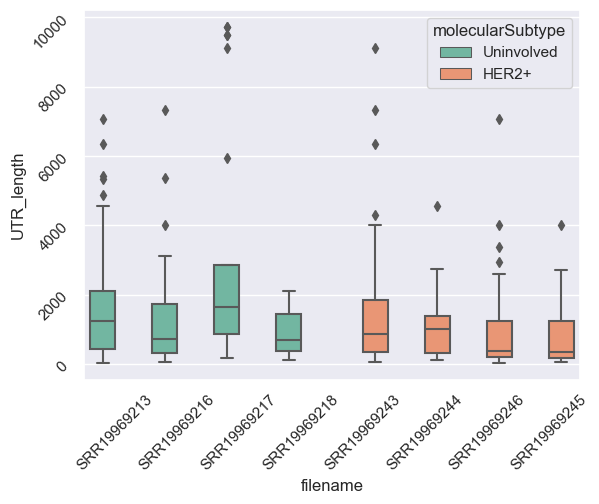

In [46]:

# Specify the variables and plot the boxplot
sns.set_context("paper")
sns.set_theme()
ax = sns.boxplot(data=merged_her_filter, x="filename", y="UTR_length", hue='molecularSubtype', palette='Set2')

# Change the angle of x-axis labels
plt.xticks(rotation=45)

# Change the angle of y-axis label
plt.yticks(rotation=45)

# Show the plot
plt.show()




In [38]:
merged_her_filter = merged_pca_her[(abs(merged_pca_her['log2FoldChange'])>2)&(merged_pca_her['baseMean']>50)]

In [51]:
merged_pca_her

,seqname,source,feature,start,end,strand,ref_gene_id,reference_id,filename,transcript_length,...,ref_UTR_length,UTR_diff,UTR_length (ln),UTR_type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
19398,chr19,StringTie,transcript,9755357,9768738,-,ZNF846,NM_001353798.2,SRR19969216,13381,...,2118,0,7.658228,no change,155.878912,-0.447742,0.150383,-2.977335,2.907664e-03,0.036350
19396,chr12,aptardi,transcript,133037509,133059653,+,ZNF84,NM_001289971.2,SRR19969216,22144,...,4367,-3646,6.580639,shorter,730.901658,-0.452191,0.133869,-3.377869,7.304989e-04,0.013302
9983,chr1,aptardi,transcript,71006885,71047816,-,PTGER3,NM_198715.3,SRR19969213,40931,...,6355,-1025,8.581107,shorter,665.183722,-2.517262,0.565605,-4.450565,8.564468e-06,0.000445
4662,chr1,StringTie,transcript,209675412,209676390,+,G0S2,NM_015714.4,SRR19969213,978,...,394,0,5.976351,no change,1491.361613,-3.751046,0.730105,-5.137679,2.781524e-07,0.000030
9982,chr1,StringTie,transcript,71005860,71047816,-,PTGER3,NM_198715.3,SRR19969213,41956,...,6355,0,8.756997,no change,665.183722,-2.517262,0.565605,-4.450565,8.564468e-06,0.000445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8851,chr11,StringTie,transcript,73272142,73298625,+,P2RY6,NM_001277208.1,SRR19969243,26483,...,1120,0,7.021084,no change,286.715835,1.634180,0.369356,4.424400,9.671074e-06,0.000494
8852,chr11,aptardi,transcript,73272142,73297884,+,P2RY6,NM_001277208.1,SRR19969245,25742,...,1120,-741,5.937536,shorter,286.715835,1.634180,0.369356,4.424400,9.671074e-06,0.000494
8305,chr1,StringTie,transcript,211662772,211675621,-,NEK2,NM_002497.4,SRR19969243,12849,...,654,0,6.483107,no change,174.167525,2.822556,0.706187,3.996896,6.417858e-05,0.002206
8414,chr17,StringTie,transcript,51153559,51162089,+,NME1,NM_198175.1,SRR19969245,8530,...,244,0,5.497168,no change,1699.391411,1.086786,0.261695,4.152878,3.283204e-05,0.001314


In [68]:
pca_concat = pd.concat([merged_pca, merged_pca_her])

In [69]:
pca_concat.to_csv('../../../DEG/HER_DEG/pca/pca_concat2.csv')